In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical


2024-04-26 16:06:10.886575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 16:06:10.886691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 16:06:11.019131: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


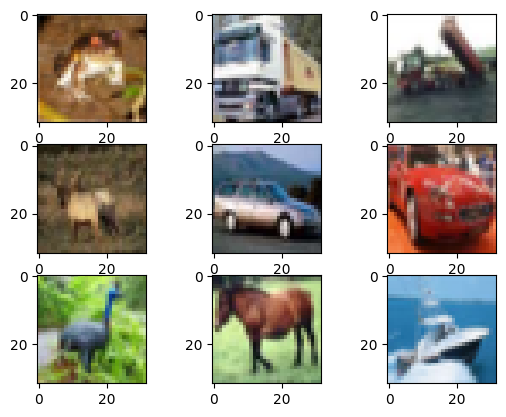

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [3]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [5]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)


In [6]:
y_train.shape

(50000, 10)

In [8]:

#the model has 6 convolutional layers, 1 flatten layer, and 2 dense layers, making it a total of 9 layers.
# Smaller than Vgg-16

reg=None
num_filters=32
ac='relu'
adm = Adam(learning_rate=0.001, decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
pip install modAL-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


> **Uncertainty Sampling (Least Confidence)**

In [85]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)


# Define the custom predict_proba function
def predict_proba_custom(model, X):
    raw_predictions = model.predict(X)
    class_probabilities = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
    return class_probabilities

# Assign the custom predict_proba function to the estimator
model.predict_proba = lambda X: predict_proba_custom(model, X)

# Initialize the ActiveLearner
learner = ActiveLearner(
    estimator=model, 
    X_training=x_labeled, 
    y_training=y_labeled, 
    query_strategy=uncertainty_sampling
)

n_queries = 10

n_samples_per_iteration = 4000  


# Training loop
for i in range(n_queries):
    
    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)
    
    queried_labels = y_unlabeled[query_idx]
    
    
    # Label the queried samples and update the labeled dataset
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
    
    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)

    
    
    # Update the learner with the newly labeled data
    learner.teach(query_sample, queried_labels)
    
    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    
    
    # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    
    
     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    
    
    
    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    
    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")

22/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1842 - loss: 3.2292

W0000 00:00:1714060173.106919      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.2454 - loss: 2.8636


W0000 00:00:1714060177.452691      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  75/1485 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

W0000 00:00:1714060179.790643      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1485/1485 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


W0000 00:00:1714060183.146777      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


X_labeled  (6500, 32, 32, 3)
y_labeled  (6500, 10)
learner x_train  (2500, 32, 32, 3)
learner y_train  (2500, 10)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3785 - loss: 2.0238
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


W0000 00:00:1714060190.577140      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1714060196.986528      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 1 - Train Accuracy: 0.2191, Train Precision: 0.4471, Train Recall: 0.2191, Train F1: 0.1893
Iteration 1 - Test Accuracy: 0.2168, Test Precision: 0.4085, Test Recall: 0.2168, Test F1: 0.1870
Iteration 1 - Labeled Accuracy: 0.2503, Labeled Precision: 0.4258, Labeled Recall: 0.2623, Labeled F1: 0.2407
Iteration 1 - unlabeled Accuracy: 0.2145, unlabeled Precision: 0.4643, unlabeled Recall: 0.2095, unlabeled F1: 0.1758
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
X_labeled  (10500, 32, 32, 3)
y_labeled  (10500, 10)
learner x_train  (6500, 32, 32, 3)
learner y_train  (6500, 10)
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5011 - loss: 1.5529
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 2 - Train Accuracy: 0.5277, Train Precision: 0.5391, Train Recall: 0.5277, Train F1: 0.5157
Iteration 2 - Test Accuracy

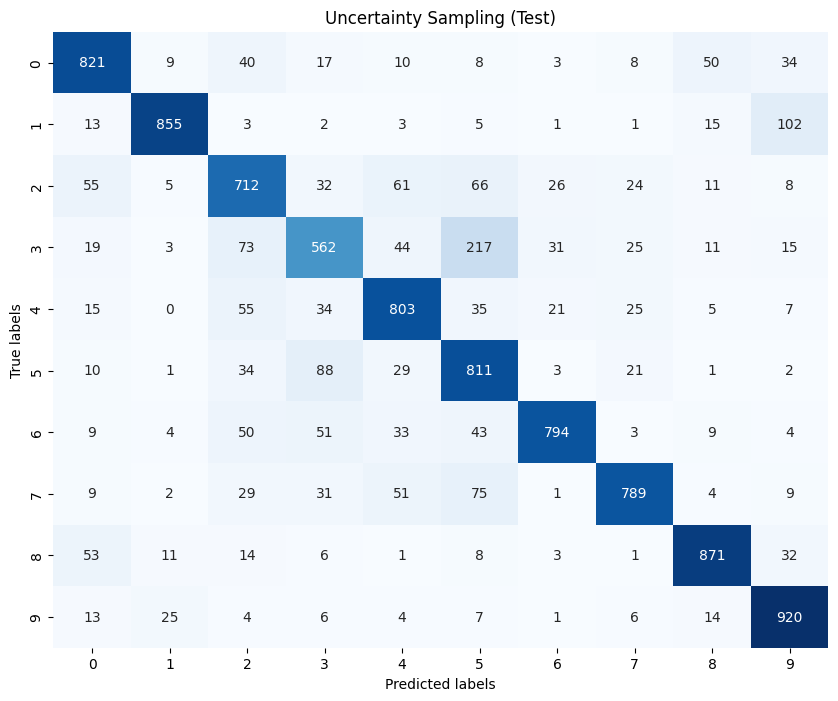

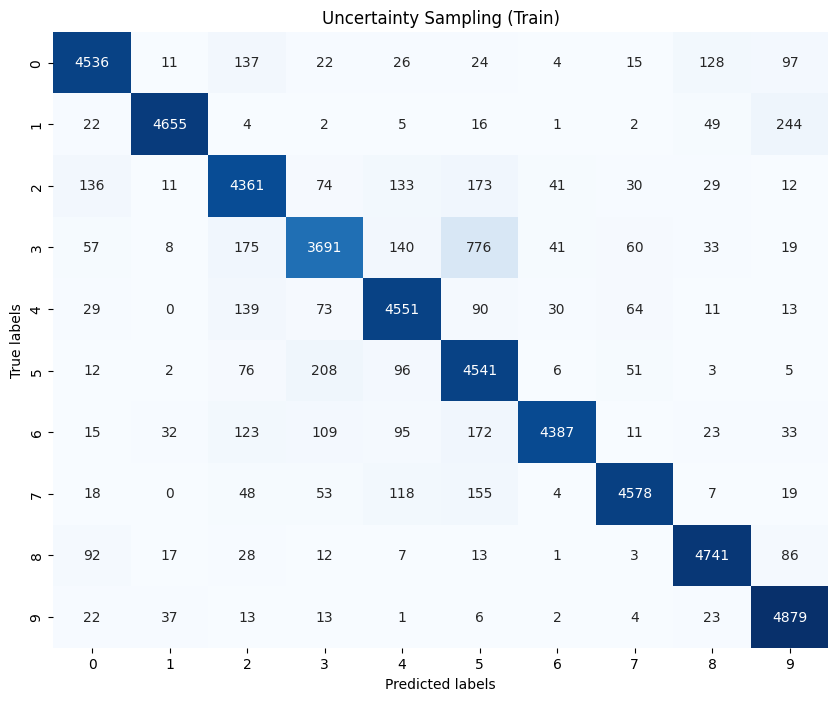

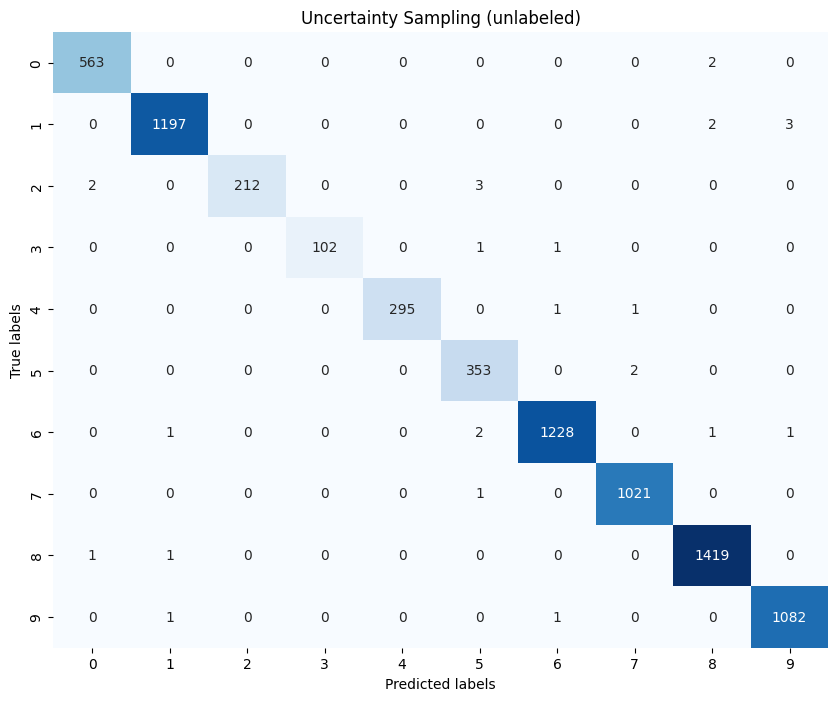

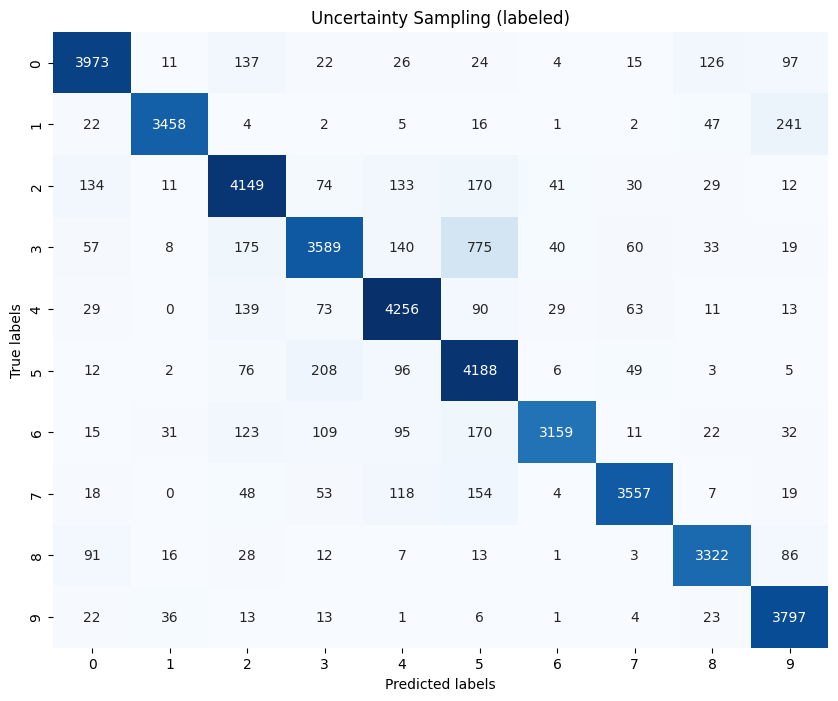

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Uncertainty Sampling (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Uncertainty Sampling (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Uncertainty Sampling (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Uncertainty Sampling (labeled)')
plt.show()




In [86]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.85      0.78      0.82      1000
           1       0.90      0.90      0.90      1000
           2       0.76      0.69      0.73      1000
           3       0.63      0.67      0.65      1000
           4       0.75      0.82      0.79      1000
           5       0.65      0.82      0.72      1000
           6       0.87      0.81      0.84      1000
           7       0.88      0.82      0.85      1000
           8       0.90      0.88      0.89      1000
           9       0.91      0.83      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      5000
           1       0.95      0.96      0.96      5000
           2       0.90      0.85      0.87      5000
           3       0.79 

> **Random Sampling**

In [94]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)


def random_sampling(classifier, X_pool,n_instances):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
    return query_idx, X_pool[query_idx]


learner = ActiveLearner(
    estimator=model, 
    X_training=x_labeled, 
    y_training=y_labeled, 
    query_strategy=random_sampling
)

n_queries = 10

n_samples_per_iteration = 4000  

# Training loop
for i in range(n_queries):

    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)
    
    queried_labels = y_unlabeled[query_idx]
    
    # Label the queried samples and update the labeled dataset
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
    
    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)

    
    
    learner.teach(query_sample, queried_labels)
    
    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    
    
    # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    
    
     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    
    
    
    
    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    
    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")

22/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1624 - loss: 3.3660

W0000 00:00:1714060573.981595      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.2223 - loss: 2.9489


W0000 00:00:1714060578.462744      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


X_labeled  (6500, 32, 32, 3)
y_labeled  (6500, 10)
learner x_train  (2500, 32, 32, 3)
learner y_train  (2500, 10)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3623 - loss: 2.0214
  81/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

W0000 00:00:1714060582.569708      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


W0000 00:00:1714060586.023728      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


W0000 00:00:1714060591.150560      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


W0000 00:00:1714060592.754858      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 1 - Train Accuracy: 0.3078, Train Precision: 0.4834, Train Recall: 0.3078, Train F1: 0.2833
Iteration 1 - Test Accuracy: 0.2978, Test Precision: 0.4907, Test Recall: 0.2978, Test F1: 0.2765
Iteration 1 - Labeled Accuracy: 0.3452, Labeled Precision: 0.5244, Labeled Recall: 0.3424, Labeled F1: 0.3183
Iteration 1 - unlabeled Accuracy: 0.3022, unlabeled Precision: 0.4770, unlabeled Recall: 0.3026, unlabeled F1: 0.2780
X_labeled  (10500, 32, 32, 3)
y_labeled  (10500, 10)
learner x_train  (6500, 32, 32, 3)
learner y_train  (6500, 10)
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4716 - loss: 1.5610
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 2 - Train Accuracy: 0.5510, Train Precision: 0.5791, Train Recall: 0.5510, Train F1: 0.5519
Iteration 2 - Test Accuracy: 0.5375, Test Precision: 0.5651, Test Reca

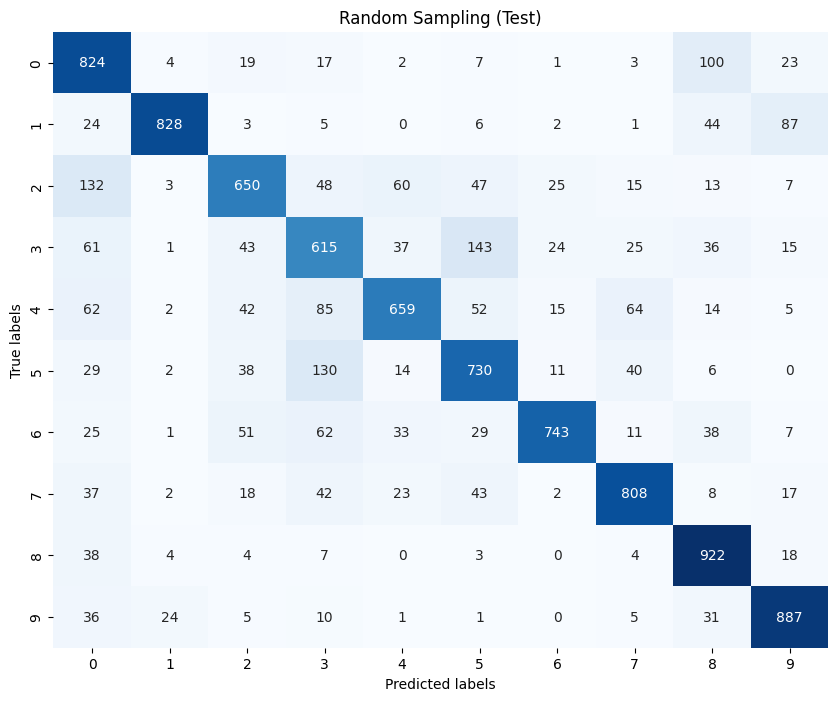

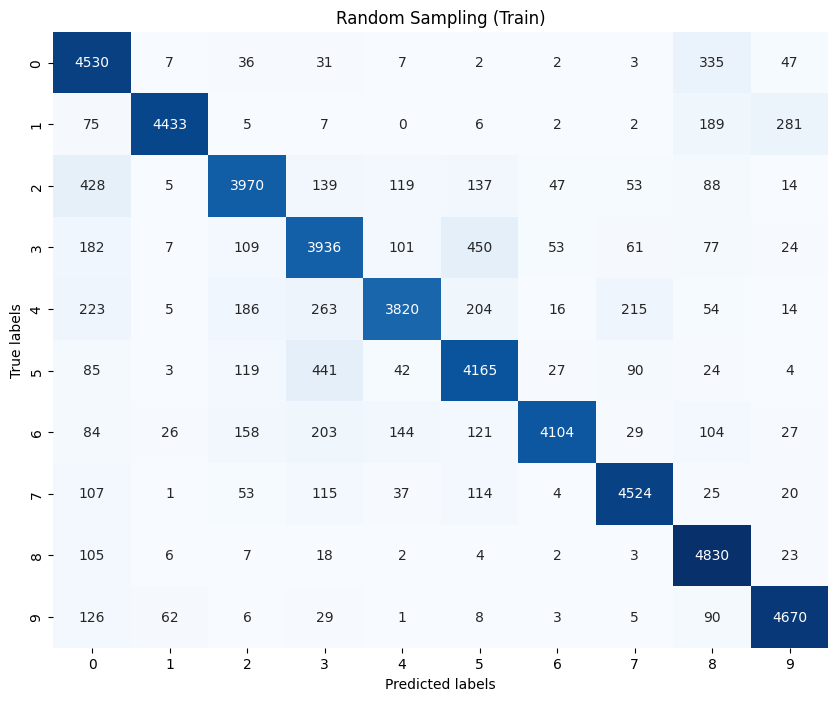

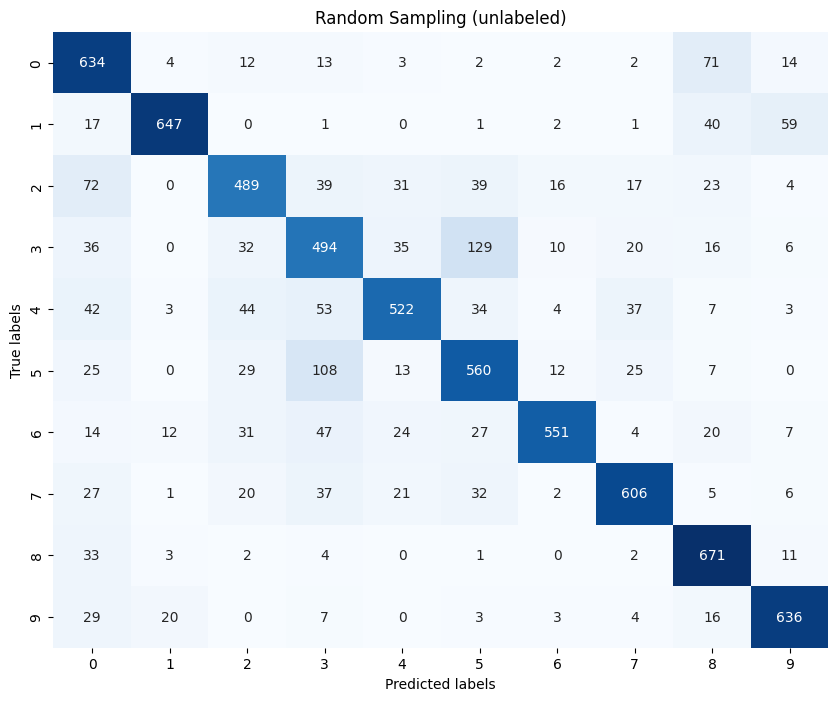

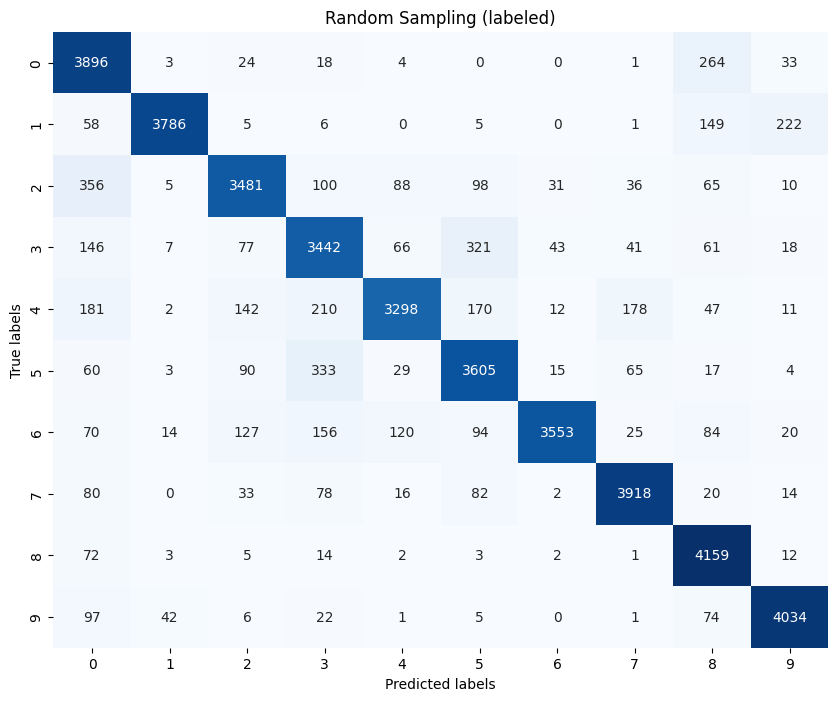

In [65]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Sampling (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Sampling (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Sampling (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Sampling (labeled)')
plt.show()




In [95]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1000
           1       0.87      0.92      0.89      1000
           2       0.62      0.77      0.68      1000
           3       0.69      0.56      0.62      1000
           4       0.76      0.76      0.76      1000
           5       0.74      0.68      0.71      1000
           6       0.82      0.84      0.83      1000
           7       0.84      0.81      0.83      1000
           8       0.87      0.87      0.87      1000
           9       0.95      0.75      0.83      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      5000
           1       0.91      0.96      0.94      5000
           2       0.74      0.89      0.81      5000
           3       0.79 

> **Margin Sampling**

In [11]:
from modAL.models import ActiveLearner
from modAL.uncertainty import margin_sampling
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)


# Define the custom predict_proba function
def predict_proba_custom(model, X):
    raw_predictions = model.predict(X)
    class_probabilities = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
    return class_probabilities

# Assign the custom predict_proba function to the estimator
model.predict_proba = lambda X: predict_proba_custom(model, X)

learner = ActiveLearner(
    estimator=model, 
    X_training=x_labeled, 
    y_training=y_labeled, 
    query_strategy=margin_sampling
)

n_queries = 10

n_samples_per_iteration = 4000 


# Training loop
for i in range(n_queries):

    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)
    
    queried_labels = y_unlabeled[query_idx]
    
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
    
    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)

    
    
    learner.teach(query_sample, queried_labels)
    
    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    
    
    # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    
    
     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    
    
    
    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    
    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")

22/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1859 - loss: 3.1301

I0000 00:00:1714147676.495513     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714147676.519415     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.2498 - loss: 2.8110


W0000 00:00:1714147682.389362     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  86/1485 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

W0000 00:00:1714147684.642987     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1485/1485 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


W0000 00:00:1714147688.488754     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


X_labeled  (6500, 32, 32, 3)
y_labeled  (6500, 10)
learner x_train  (2500, 32, 32, 3)
learner y_train  (2500, 10)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3996 - loss: 1.8927
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


W0000 00:00:1714147696.449795     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


W0000 00:00:1714147703.034551     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 1 - Train Accuracy: 0.3055, Train Precision: 0.4802, Train Recall: 0.3055, Train F1: 0.2719
Iteration 1 - Test Accuracy: 0.3096, Test Precision: 0.4885, Test Recall: 0.3096, Test F1: 0.2782
Iteration 1 - Labeled Accuracy: 0.3848, Labeled Precision: 0.5449, Labeled Recall: 0.3520, Labeled F1: 0.3386
Iteration 1 - unlabeled Accuracy: 0.2937, unlabeled Precision: 0.4668, unlabeled Recall: 0.2956, unlabeled F1: 0.2595
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
X_labeled  (10500, 32, 32, 3)
y_labeled  (10500, 10)
learner x_train  (6500, 32, 32, 3)
learner y_train  (6500, 10)
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4615 - loss: 1.5851
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 2 - Train Accuracy: 0.5692, Train Precision: 0.5684, Train Recall: 0.5692, Train F1: 0.5516
Iteration 2 - Test Accuracy

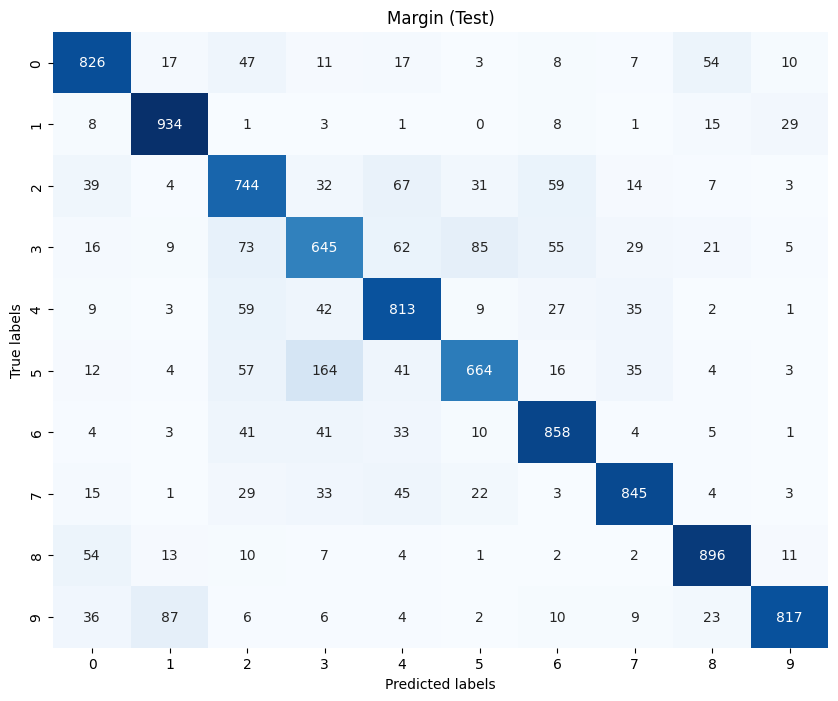

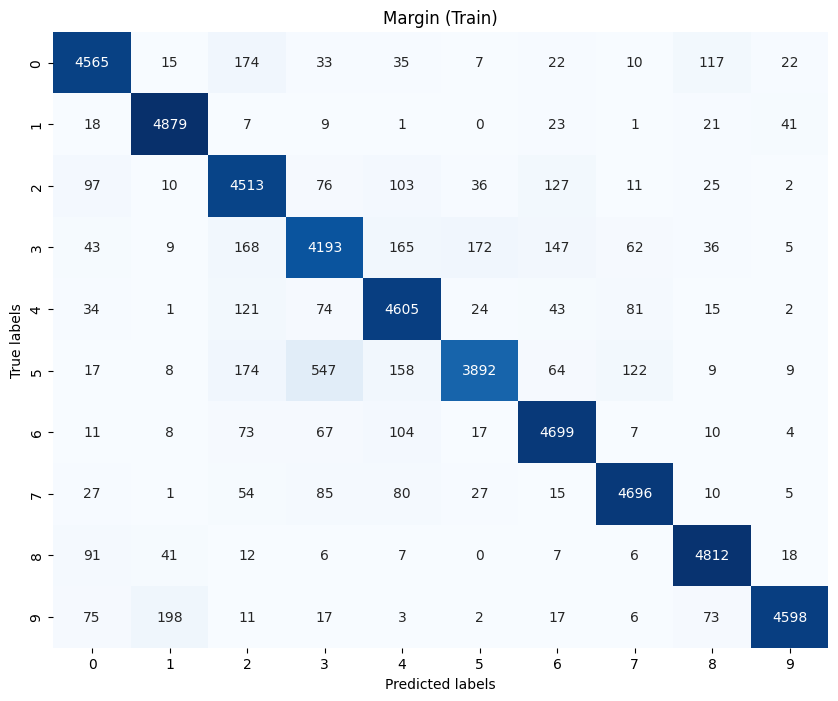

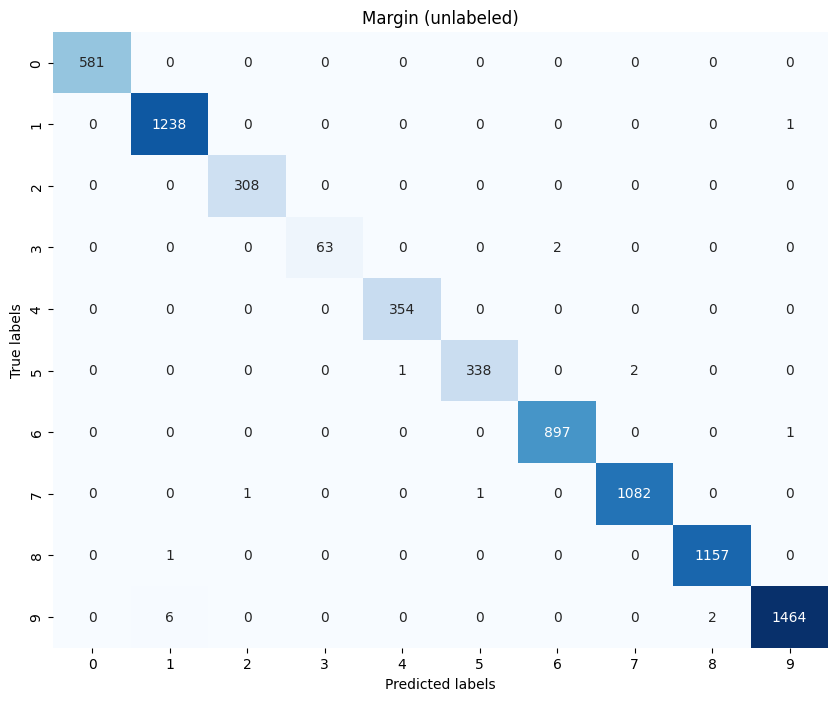

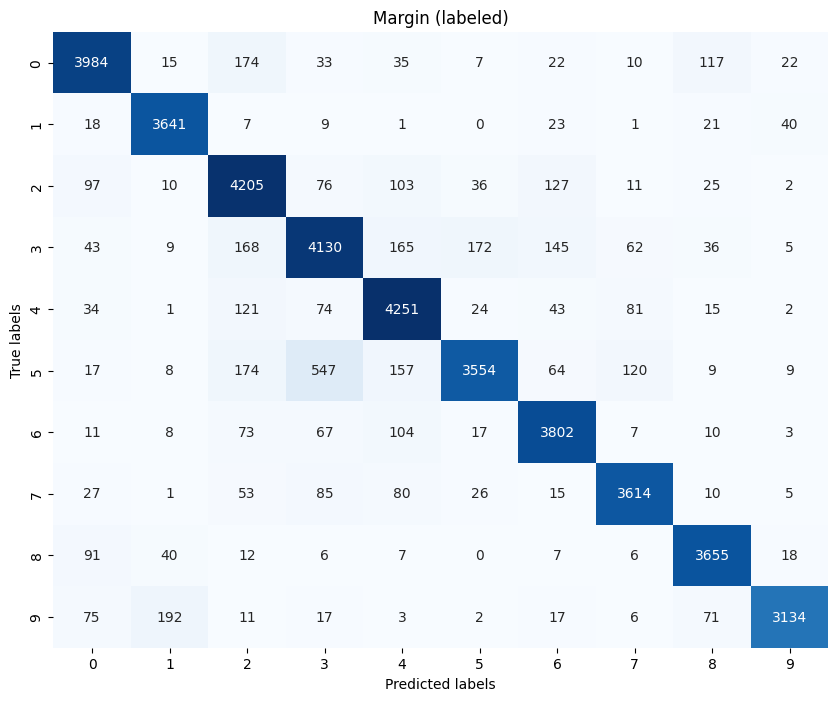

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Margin (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Margin (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Margin (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Margin (labeled)')
plt.show()




In [13]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.87      0.93      0.90      1000
           2       0.70      0.74      0.72      1000
           3       0.66      0.65      0.65      1000
           4       0.75      0.81      0.78      1000
           5       0.80      0.66      0.73      1000
           6       0.82      0.86      0.84      1000
           7       0.86      0.84      0.85      1000
           8       0.87      0.90      0.88      1000
           9       0.93      0.82      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      5000
           1       0.94      0.98      0.96      5000
           2       0.85      0.90      0.88      5000
           3       0.82 

**Entropy Sampling****

In [75]:
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)



# Define the custom predict_proba function
def predict_proba_custom(model, X):
    raw_predictions = model.predict(X)
    class_probabilities = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
    return class_probabilities

# Assign the custom predict_proba function to the estimator
model.predict_proba = lambda X: predict_proba_custom(model, X)


learner = ActiveLearner(
    estimator=model, 
    X_training=x_labeled, 
    y_training=y_labeled, 
    query_strategy=entropy_sampling
)

n_queries = 10

n_samples_per_iteration = 4000  


# Training loop
for i in range(n_queries):

    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)
    
    queried_labels = y_unlabeled[query_idx]
    
    # Label the queried samples and update the labeled dataset
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
    
    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)

    
    
    learner.teach(query_sample, queried_labels)
    
    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    
    
    # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    
    
     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    
    
    
    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    
    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")

22/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1789 - loss: 3.1667

W0000 00:00:1714059261.001080      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.2357 - loss: 2.8540


W0000 00:00:1714059265.402424      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  77/1485 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

W0000 00:00:1714059267.747279      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1485/1485 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


W0000 00:00:1714059271.090097      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


X_labeled  (6500, 32, 32, 3)
y_labeled  (6500, 10)
learner x_train  (2500, 32, 32, 3)
learner y_train  (2500, 10)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3635 - loss: 2.0703
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


W0000 00:00:1714059278.289512      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


W0000 00:00:1714059284.701287      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 1 - Train Accuracy: 0.2161, Train Precision: 0.3976, Train Recall: 0.2161, Train F1: 0.1744
Iteration 1 - Test Accuracy: 0.2174, Test Precision: 0.3769, Test Recall: 0.2174, Test F1: 0.1728
Iteration 1 - Labeled Accuracy: 0.2506, Labeled Precision: 0.4112, Labeled Recall: 0.2485, Labeled F1: 0.1948
Iteration 1 - unlabeled Accuracy: 0.2109, unlabeled Precision: 0.3922, unlabeled Recall: 0.2108, unlabeled F1: 0.1700
1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
X_labeled  (10500, 32, 32, 3)
y_labeled  (10500, 10)
learner x_train  (6500, 32, 32, 3)
learner y_train  (6500, 10)
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4924 - loss: 1.5613
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 2 - Train Accuracy: 0.5326, Train Precision: 0.5447, Train Recall: 0.5326, Train F1: 0.5229
Iteration 2 - Test Accuracy

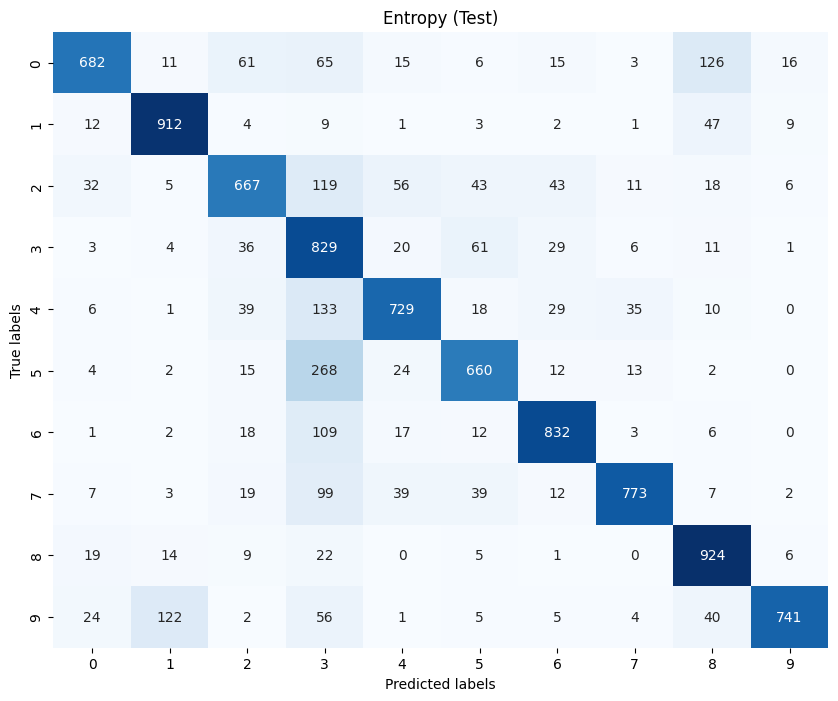

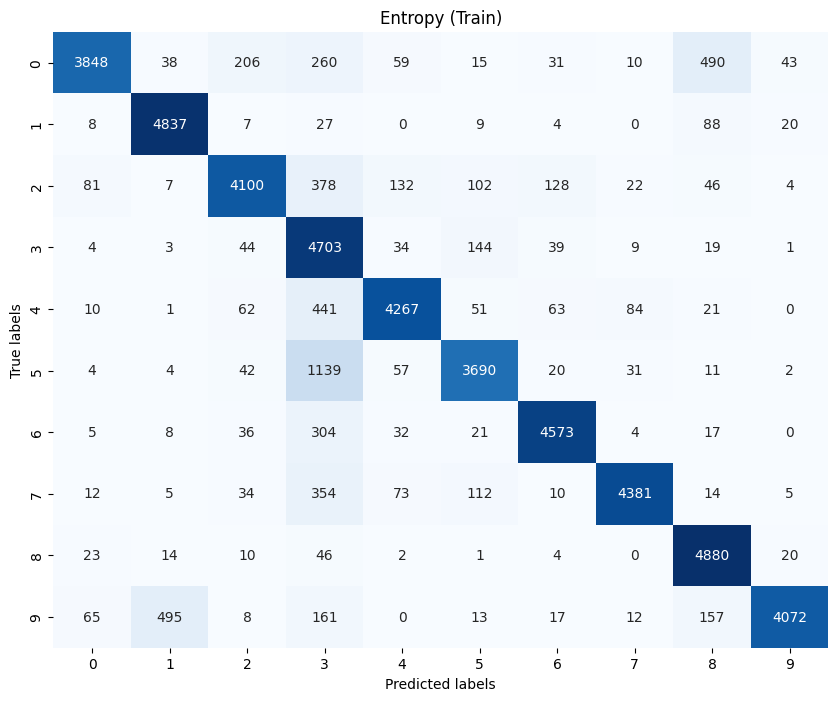

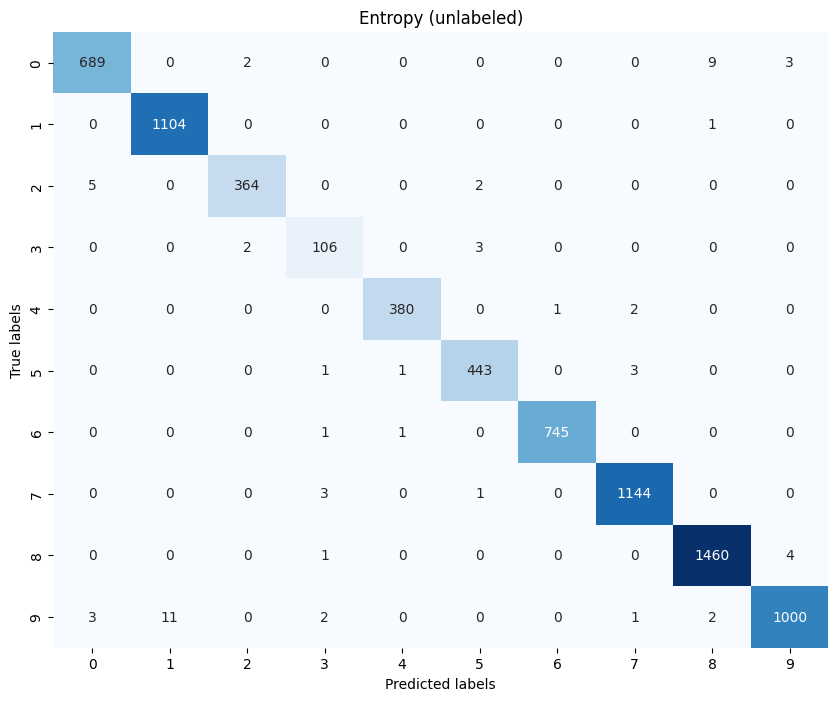

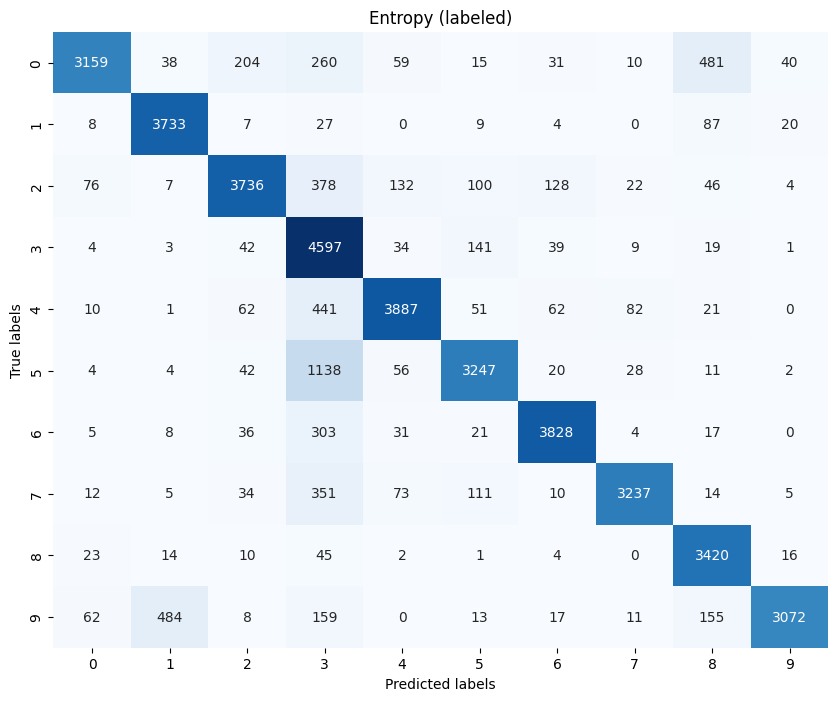

In [76]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Entropy (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Entropy (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Entropy (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Entropy (labeled)')
plt.show()




In [77]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.86      0.68      0.76      1000
           1       0.85      0.91      0.88      1000
           2       0.77      0.67      0.71      1000
           3       0.49      0.83      0.61      1000
           4       0.81      0.73      0.77      1000
           5       0.77      0.66      0.71      1000
           6       0.85      0.83      0.84      1000
           7       0.91      0.77      0.84      1000
           8       0.78      0.92      0.84      1000
           9       0.95      0.74      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.80      0.77      0.78     10000
weighted avg       0.80      0.77      0.78     10000

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      5000
           1       0.89      0.97      0.93      5000
           2       0.90      0.82      0.86      5000
           3       0.60 

> **Density-Based Sampling**

In [103]:
from sklearn.neighbors import KernelDensity
from modAL.models import ActiveLearner
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)


from sklearn.decomposition import PCA

def density_based_sampling(classifier, X_pool, n_instances):
    pca = PCA(n_components=2) 
    X_pool_reduced = pca.fit_transform(X_pool.reshape(len(X_pool), -1))
    
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(X_pool_reduced)
    
    density_scores = kde.score_samples(X_pool_reduced)
    
    query_idx = np.argsort(density_scores)[-n_instances:]
    
    return query_idx, X_pool[query_idx]


learner = ActiveLearner(
    estimator=model, 
    X_training=x_labeled, 
    y_training=y_labeled, 
    query_strategy=density_based_sampling
)

n_queries = 10
n_samples_per_iteration = 4000

# Training loop
for i in range(n_queries):
    
    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)
    
    queried_labels = y_unlabeled[query_idx]
    
    # Label the queried samples and update the labeled dataset
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
    
    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)

    
    
    learner.teach(query_sample, queried_labels)
    
    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    
    
     # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    
    
     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    
    
    
    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    
    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")


22/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1915 - loss: 3.2171

W0000 00:00:1714060937.819051      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.2553 - loss: 2.8513


W0000 00:00:1714060942.254410      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


X_labeled  (6500, 32, 32, 3)
y_labeled  (6500, 10)
learner x_train  (2500, 32, 32, 3)
learner y_train  (2500, 10)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3553 - loss: 2.0460
  80/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

W0000 00:00:1714061042.769796      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


W0000 00:00:1714061046.268169      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1360/1360 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


W0000 00:00:1714061051.489435      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


W0000 00:00:1714061053.104627      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 1 - Train Accuracy: 0.3188, Train Precision: 0.4325, Train Recall: 0.3188, Train F1: 0.2947
Iteration 1 - Test Accuracy: 0.3212, Test Precision: 0.4380, Test Recall: 0.3212, Test F1: 0.2993
Iteration 1 - Labeled Accuracy: 0.3442, Labeled Precision: 0.4740, Labeled Recall: 0.3466, Labeled F1: 0.3214
Iteration 1 - unlabeled Accuracy: 0.3150, unlabeled Precision: 0.4270, unlabeled Recall: 0.3145, unlabeled F1: 0.2909
X_labeled  (10500, 32, 32, 3)
y_labeled  (10500, 10)
learner x_train  (6500, 32, 32, 3)
learner y_train  (6500, 10)
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4388 - loss: 1.6451
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1235/1235 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Iteration 2 - Train Accuracy: 0.5249, Train Precision: 0.5607, Train Recall: 0.5249, Train F1: 0.5263
Iteration 2 - Test Accuracy: 0.5149, Test Precision: 0.5484, Test Reca

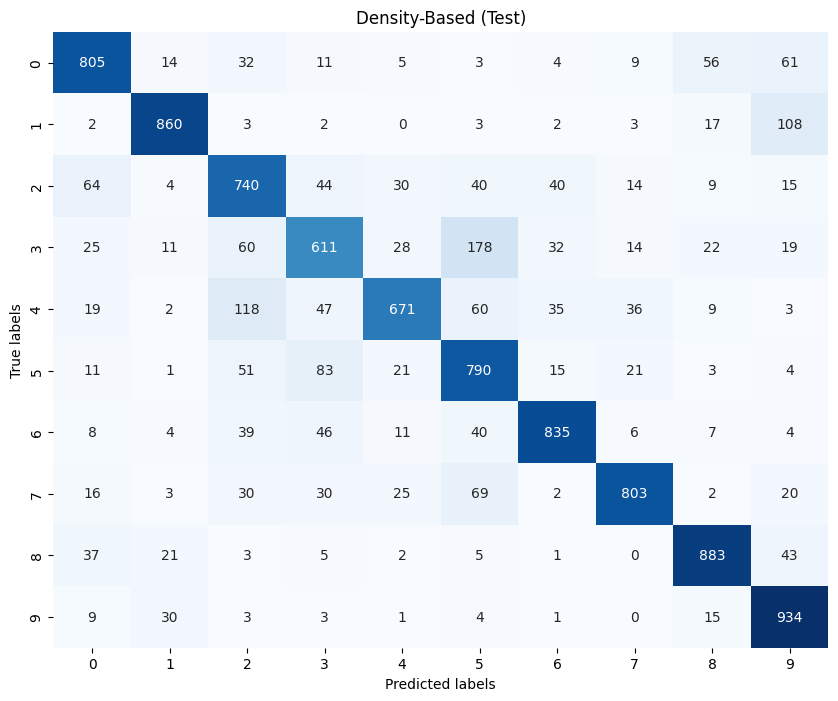

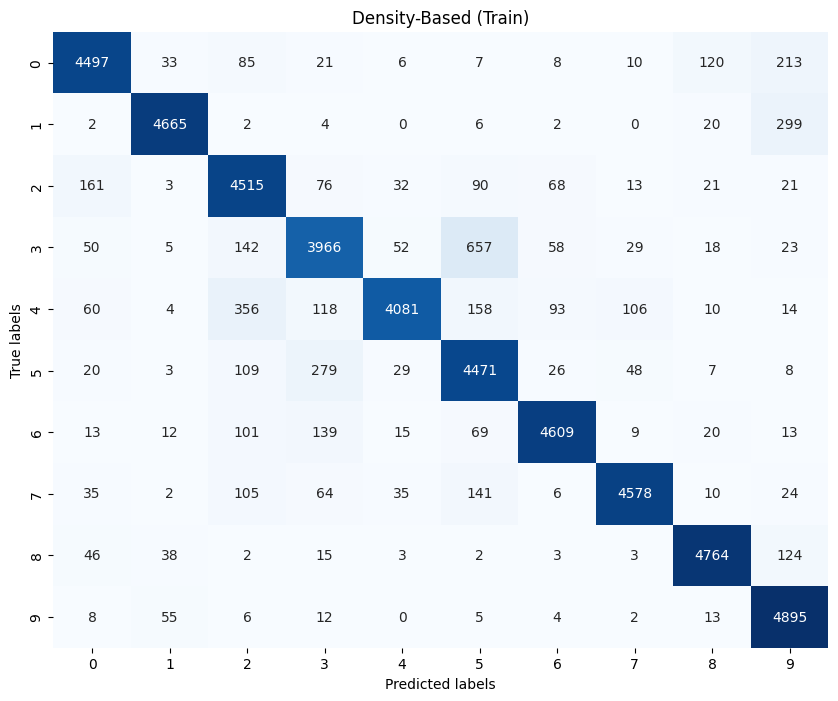

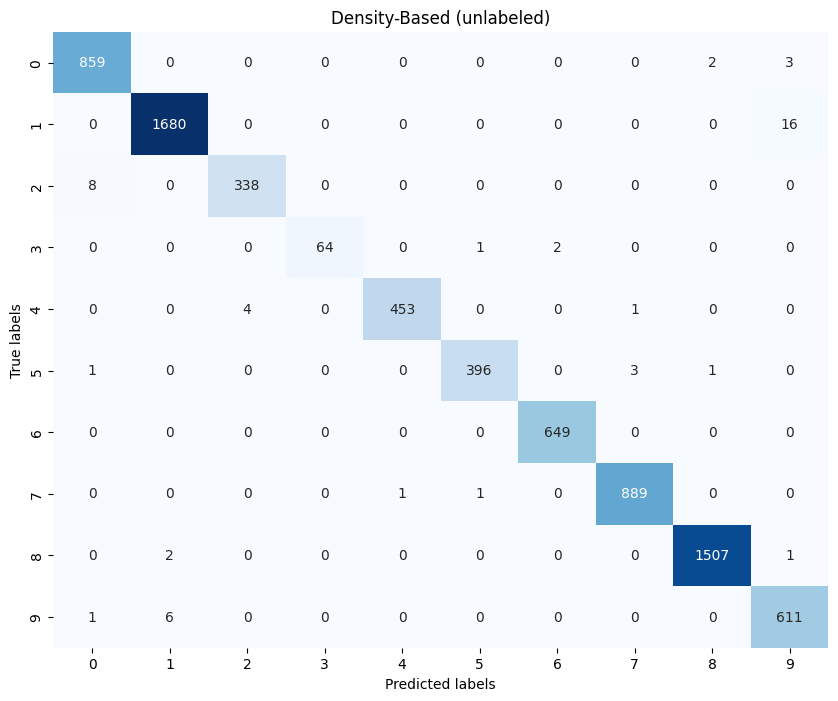

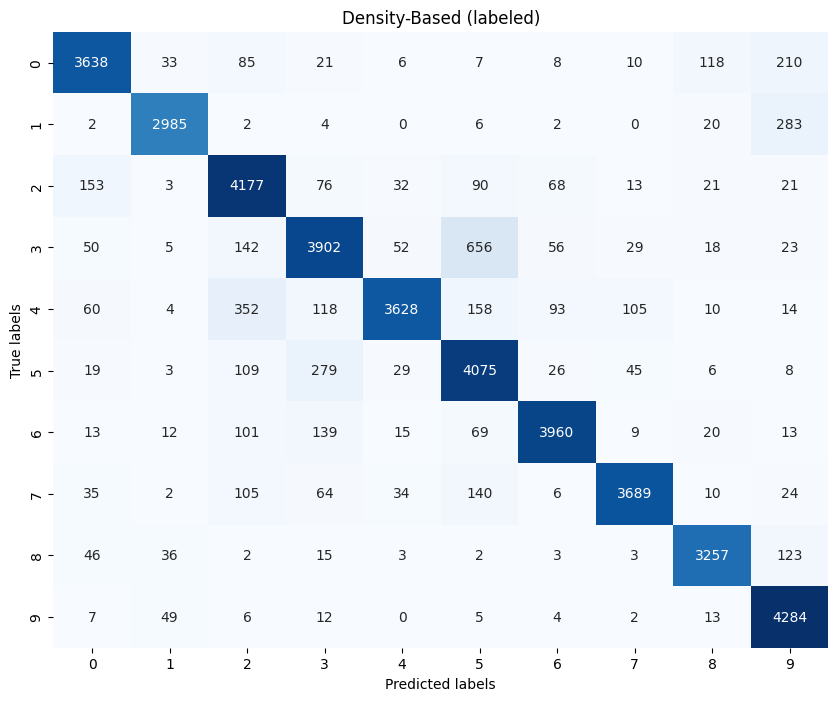

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Density-Based (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Density-Based (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Density-Based (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Density-Based (labeled)')
plt.show()




In [104]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1000
           1       0.91      0.88      0.89      1000
           2       0.73      0.69      0.71      1000
           3       0.59      0.65      0.62      1000
           4       0.80      0.70      0.75      1000
           5       0.65      0.77      0.71      1000
           6       0.87      0.81      0.84      1000
           7       0.82      0.88      0.85      1000
           8       0.94      0.81      0.87      1000
           9       0.89      0.86      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5000
           1       0.96      0.94      0.95      5000
           2       0.85      0.82      0.83      5000
           3       0.74 